In [ ]:
!pip install shap
!pip install ultralytics
!git clone https://github.com/ultralytics/ultralytics/

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 722.0/722.0 kB 7.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 33.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.6/823.6 kB 44.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 36.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 731.7/731.7 MB 2.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.6/410.6 MB 3.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.6/121.6 MB 8.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.5/56.5 MB 12.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 124.2/124.2 MB 6.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 196.0/196.0 MB 5.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 166.0/166.0 MB 7.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.1/99.1 kB 8.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━

Cloning into 'ultralytics'...
remote: Enumerating objects: 23163, done.
remote: Counting objects: 100% (194/194), done.
remote: Compressing objects: 100% (146/146), done.
remote: Total 23163 (delta 100), reused 95 (delta 48), pack-reused 22969
Receiving objects: 100% (23163/23163), 13.77 MiB | 20.59 MiB/s, done.
Resolving deltas: 100% (16191/16191), done.


In [ ]:
%cd ultralytics/ultralytics

/content/ultralytics/ultralytics


In [ ]:
import json
import random

from PIL import Image
import torch
import torch.backends.cudnn as cudnn
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import shap
import cv2

from ultralytics import YOLO
from utils.ops import non_max_suppression
from utils.metrics import box_iou

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
img_size = 5*32   # must be multiple of 32
img_path = "./car_rear.jpeg"   # image path
conf = 0.5
iou = 0.5
model = YOLO("yolov8m.pt")    # load your model here

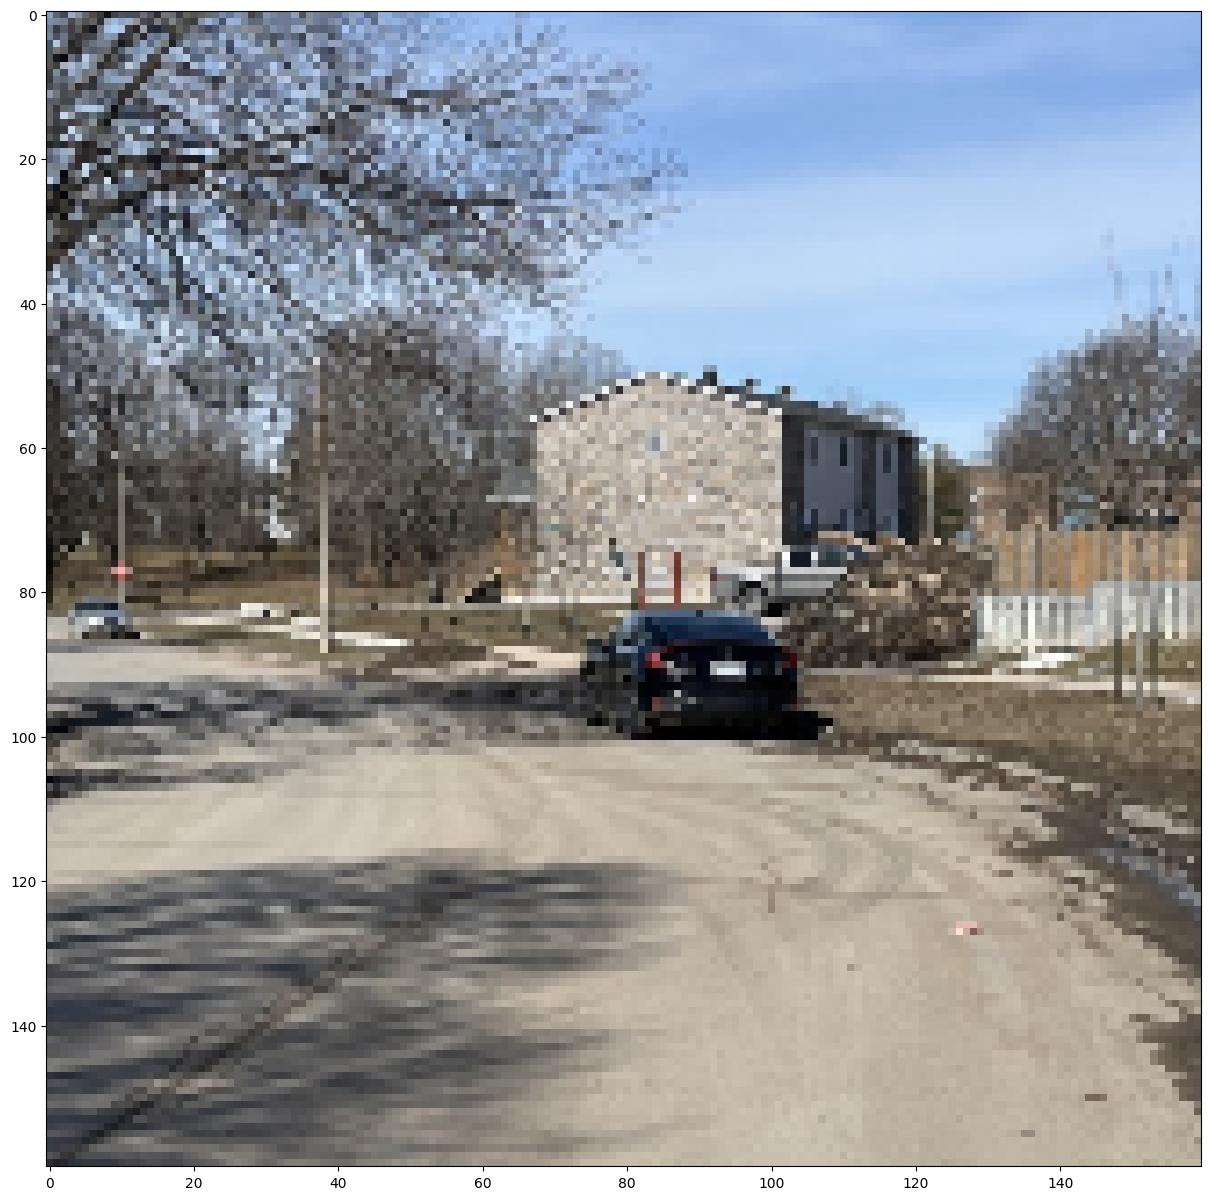

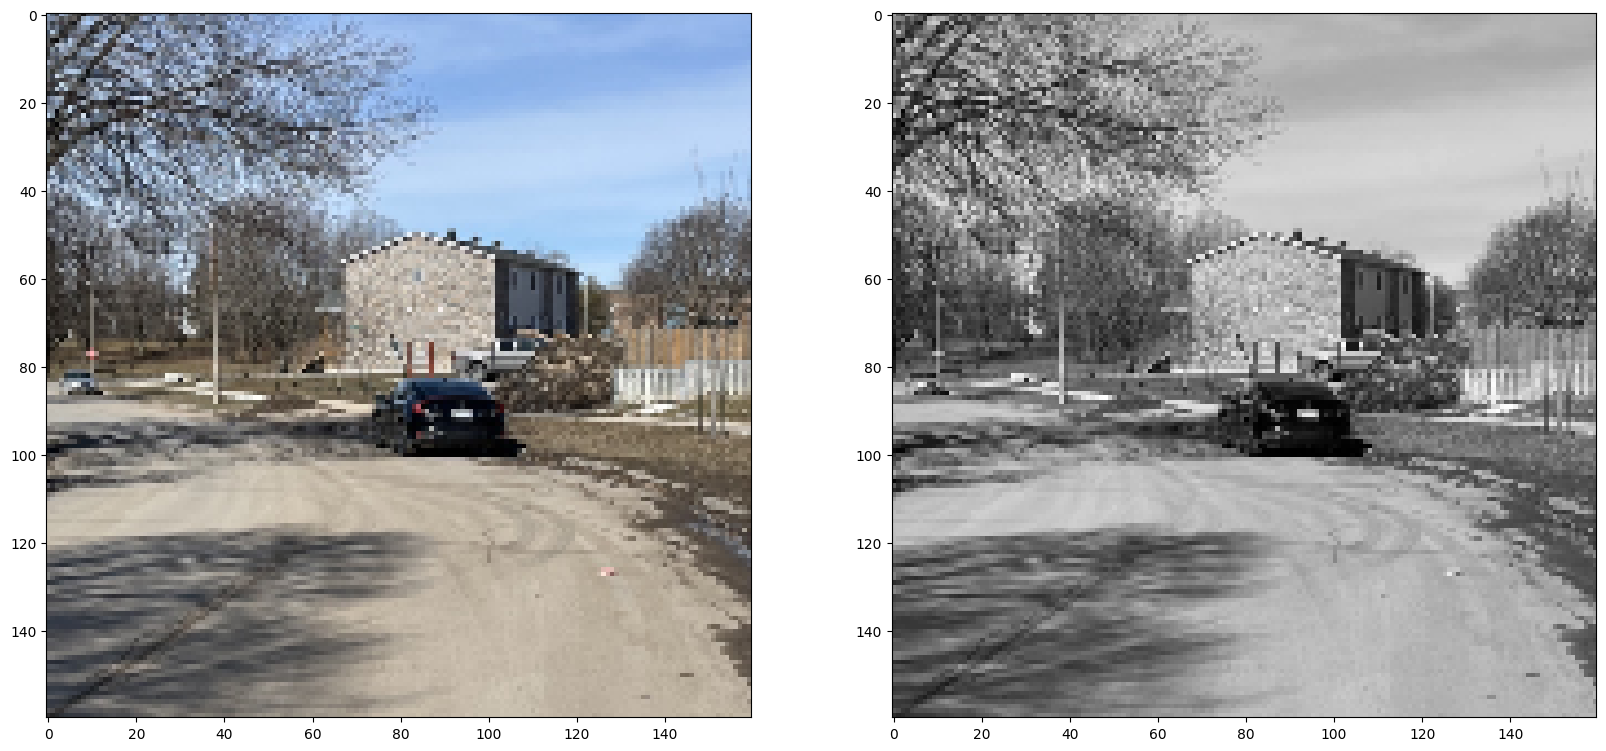

In [ ]:
def preprocess(img_path, img_size):

  img_org = cv2.imread(img_path, cv2.IMREAD_COLOR)
  img_org = cv2.cvtColor(img_org, cv2.COLOR_BGR2RGB)

  old_img_size = img_org.shape[:2] # old size is in (height, width) format

  ratio = float(img_size)/max(old_img_size)
  new_size_y, new_size_x = tuple([int(x*ratio) for x in old_img_size])

  img = cv2.resize(img_org, (new_size_x, new_size_y))

  delta_w = img_size - new_size_x
  delta_h = img_size - new_size_y
  top, bottom = delta_h//2, delta_h-(delta_h//2)
  left, right = delta_w//2, delta_w-(delta_w//2)
  colour = [0, 0, 0]

  img = cv2.copyMakeBorder(img, top, bottom, left, right, cv2.BORDER_CONSTANT, value=colour)
  img = img.astype("float64")/255

  img_gray = np.dot(img[...,:3], [0.2989, 0.5870, 0.1140])

  plt.figure(figsize=(15, 15))
  plt.imshow(img)
  plt.show()

  fig = plt.figure(figsize=(20, 40))
  plt.subplot(1, 2, 1)
  plt.imshow(img)
  plt.subplot(1, 2, 2)
  plt.imshow(img_gray, cmap='gray', vmin=0, vmax=1)
  plt.show()
  return img_org, img, img_gray

img_org, img, img_gray = preprocess(img_path, img_size)

In [ ]:
def model_pred(img, conf, iou):

  torch_image = torch.from_numpy(np.ascontiguousarray(img.transpose(2, 0, 1))).to(device).unsqueeze(0)

  prediction = model.predict(torch_image, iou=iou, conf=conf)
  print(prediction[0].boxes.shape)
  output = prediction[0].boxes.data
  print(output, "#[x1, y1, x2, y2, class prob.*obj. score, class_index]")

  for pred in prediction:
      im_array = pred.plot()
      im = Image.fromarray(im_array[..., ::-1])
      im.show()
  return output, prediction

output, prediction = model_pred(img, conf, iou)



0: 160x160 1 car, 368.5ms
0: 160x160 1 car, 368.5ms
Speed: 0.3ms preprocess, 368.5ms inference, 37.9ms postprocess per image at shape (1, 3, 160, 160)
Speed: 0.3ms preprocess, 368.5ms inference, 37.9ms postprocess per image at shape (1, 3, 160, 160)
torch.Size([1, 6])
tensor([[ 73.9031,  82.2776, 105.8093, 100.8143,   0.7907,   2.0000]]) #[x1, y1, x2, y2, class prob.*obj. score, class_index]


In [ ]:
class CastNumpy(torch.nn.Module):
  def __init__(self):
    super(CastNumpy, self).__init__()

  def forward(self, image):
    """
    In the forward function we accept the inputs and cast them to a pytorch tensor
    """

    image = np.ascontiguousarray(image)
    image = torch.from_numpy(image).to(device)
    if image.ndimension() == 3:
      image = image.unsqueeze(0)
    image_half = image.half()

    return image_half

numpy2torch_converter = CastNumpy()
numpy2torch_converter.forward(img.transpose(2, 0, 1))

tensor([[[[0.5449, 0.3372, 0.2666,  ..., 0.5923, 0.5884, 0.5806],
          [0.4902, 0.4824, 0.4785,  ..., 0.5845, 0.5806, 0.5806],
          [0.4392, 0.2118, 0.3491,  ..., 0.5767, 0.5767, 0.5728],
          ...,
          [0.2196, 0.2196, 0.2432,  ..., 0.7021, 0.7412, 0.7061],
          [0.3293, 0.2981, 0.2196,  ..., 0.7373, 0.7021, 0.7178],
          [0.1804, 0.1372, 0.1530,  ..., 0.7490, 0.7529, 0.7490]],

         [[0.6235, 0.3921, 0.2825,  ..., 0.7217, 0.7178, 0.7100],
          [0.5527, 0.5293, 0.4980,  ..., 0.7139, 0.7100, 0.7100],
          [0.4707, 0.2432, 0.3647,  ..., 0.7100, 0.7100, 0.7061],
          ...,
          [0.2432, 0.2313, 0.2510,  ..., 0.6548, 0.6943, 0.6587],
          [0.3254, 0.2942, 0.2118,  ..., 0.6943, 0.6587, 0.6704],
          [0.1765, 0.1372, 0.1608,  ..., 0.7061, 0.7100, 0.7061]],

         [[0.7295, 0.4587, 0.3215,  ..., 0.9292, 0.9253, 0.9175],
          [0.6470, 0.6274, 0.5488,  ..., 0.9214, 0.9175, 0.9214],
          [0.5410, 0.2705, 0.3882,  ..., 0

In [ ]:
class OD2Score(torch.nn.Module):
  def __init__(self, target, conf_thresh=0.01, iou_thresh=0.5):
    super(OD2Score, self).__init__()
    self.conf_thresh = conf_thresh
    self.iou_thresh = iou_thresh
    self.target = torch.tensor(target, device=device)

  def forward(self, pred):
    """
    In the forward function we accept the predictions and return the score for a selected target of the box
    """

    score_best_box = torch.zeros(len(pred))

    for idx, img in enumerate(pred):
      result = img.boxes.data

      if result is not None:
        correct_class_predictions = result[...,5] == self.target[5]
        correctly_labeled_boxes = result[correct_class_predictions]

        if correctly_labeled_boxes.shape[0]:
          iou_with_target, _idx = box_iou(correctly_labeled_boxes[:, :4], self.target.unsqueeze(0)[:,:4]).max(1)
          index_best_box_in_correct_cls = torch.argmax(iou_with_target)
          index_best_box_in_output = torch.where(result[...,5] == self.target[5])[0][index_best_box_in_correct_cls]

          score_best_box[idx] = result[index_best_box_in_output][4]*iou_with_target[index_best_box_in_correct_cls]

    return score_best_box.cpu().numpy()

# look at the image output above and set the index of the object you want to analyze here
target_index = 0    # Change this number to index of the object detected
target = output.numpy()[target_index]
scoring = OD2Score(target, conf, iou)
print(scoring.forward(prediction), "# score for target prediction")

[    0.79074] # score for target prediction


In [ ]:
class SuperPixler(torch.nn.Module):
  def __init__(self, image, super_pixel_width):
    super(SuperPixler, self).__init__()

    self.image = image.transpose(2, 0, 1) # model expects images in BRG, not RGB, so transpose color channels
    self.mean_color = self.image.mean()
    self.image = np.expand_dims(self.image, axis=0)
    self.image_width = image.shape[1]
    self.super_pixel_width = super_pixel_width


  def forward(self, x):
    """
    In the forward step we accept the super pixel masks and transform them to a batch of images
    """

    pixeled_image = np.repeat(self.image.copy(), x.shape[0], axis=0)

    for i, super_pixel in enumerate(x.T):
      images_to_pixelate = [bool(p) for p in super_pixel]
      x = (i*self.super_pixel_width//self.image_width)*self.super_pixel_width
      y = i*self.super_pixel_width%self.image_width
      pixeled_image[images_to_pixelate,:,x:x+self.super_pixel_width, y:y+self.super_pixel_width] = self.mean_color

    return pixeled_image

super_pixel_width = 16
assert (img_size/super_pixel_width)%1 == 0, "image width needs to be multiple of super pixel width"
n_super_pixel = int((img.shape[1]/super_pixel_width)**2)

super_pixler = SuperPixler(img, super_pixel_width = super_pixel_width)

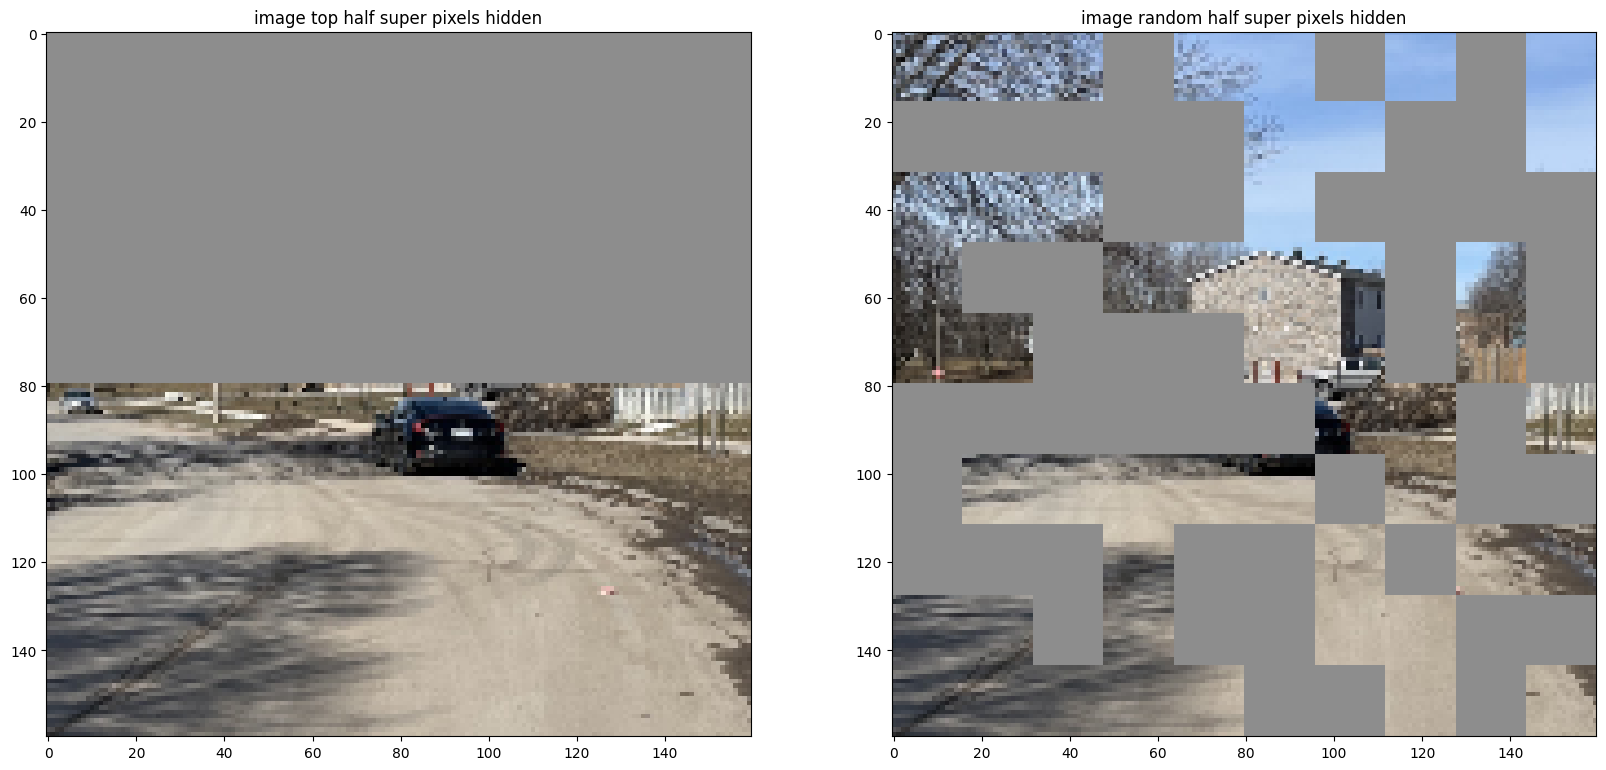

In [ ]:
img_s = super_pixler.forward(np.array([[1 for _ in range(n_super_pixel//2)]+[0 for _ in range(n_super_pixel//2)],
                                       [random.randint(0,1) for _ in range(n_super_pixel)]]))
fig = plt.figure(figsize=(20,20))
ax1 = fig.add_subplot(1,2,1)
ax1.set_title("image top half super pixels hidden")
ax1.imshow(img_s[0,:,:,:].transpose(1,2,0))
ax2 = fig.add_subplot(1,2,2)
ax2.set_title("image random half super pixels hidden")
ax2.imshow(img_s[1,:,:,:].transpose(1,2,0))
plt.show()

In [ ]:
super_pixel_model = torch.nn.Sequential(
    super_pixler,
    numpy2torch_converter,
    model,
    scoring
)

score = super_pixel_model(np.array([[1 for _ in range(n_super_pixel)]]))
print(score, "# score for whole image hidden")
score = super_pixel_model(np.array([[1 for _ in range(n_super_pixel)], # empty image
                                    [0 for _ in range(n_super_pixel)], # full image
                                    [1 for _ in range(n_super_pixel//2)]+[0 for _ in range(n_super_pixel//2)], # top half blacked out
                                    [random.randint(0,1) for _ in range(n_super_pixel)]])) # randomly half the patches blacked out
print(score, "# scores for all, none, top half, random half of the image hidden")



0: 160x160 (no detections), 199.2ms
0: 160x160 (no detections), 199.2ms
Speed: 0.6ms preprocess, 199.2ms inference, 5.4ms postprocess per image at shape (1, 3, 160, 160)
Speed: 0.6ms preprocess, 199.2ms inference, 5.4ms postprocess per image at shape (1, 3, 160, 160)
[          0] # score for whole image hidden


0: 160x160 (no detections), 124.2ms
1: 160x160 2 cars, 124.2ms
2: 160x160 2 cars, 124.2ms
3: 160x160 (no detections), 124.2ms
0: 160x160 (no detections), 124.2ms
1: 160x160 2 cars, 124.2ms
2: 160x160 2 cars, 124.2ms
3: 160x160 (no detections), 124.2ms
Speed: 0.1ms preprocess, 124.2ms inference, 0.7ms postprocess per image at shape (1, 3, 160, 160)
Speed: 0.1ms preprocess, 124.2ms inference, 0.7ms postprocess per image at shape (1, 3, 160, 160)
[          0     0.79063     0.76187           0] # scores for all, none, top half, random half of the image hidden


In [ ]:
# use Kernel SHAP to explain the detection
background_super_pixel = np.array([[1 for _ in range(n_super_pixel)]])
image_super_pixel = np.array([[0 for _ in range(n_super_pixel)]])
kernel_explainer = shap.KernelExplainer(super_pixel_model, background_super_pixel)

# Very large values for nsamples cause OOM errors depending on image and super pixel parameter. We combine batches of SHAP values to distribute the load.
collected_shap_values = np.zeros_like(background_super_pixel)
b = 10
for i in range(b):
  print(f"{i/b:0.2%}")

  shap_values = kernel_explainer.shap_values(image_super_pixel, nsamples=1000)

  # take shap value with highest abs. value for each pixel from each batch
  stacked_values = np.vstack([shap_values, collected_shap_values])
  index_max_values = np.argmax(np.abs(stacked_values), axis=0)
  collected_shap_values = stacked_values[index_max_values, range(shap_values.shape[1])]
print((collected_shap_values!=0).sum(), "non-zero shap values found")

# plot the found SHAP values. Expected value does not match due to merging of batches
shap.initjs()
shap.force_plot(kernel_explainer.expected_value, collected_shap_values)



0: 160x160 (no detections), 554.7ms
0: 160x160 (no detections), 554.7ms
Speed: 0.2ms preprocess, 554.7ms inference, 1.4ms postprocess per image at shape (1, 3, 160, 160)
Speed: 0.2ms preprocess, 554.7ms inference, 1.4ms postprocess per image at shape (1, 3, 160, 160)
0.00%


  0%|          | 0/1 [00:00<?, ?it/s]



0: 160x160 2 cars, 606.4ms
0: 160x160 2 cars, 606.4ms
Speed: 0.1ms preprocess, 606.4ms inference, 18.0ms postprocess per image at shape (1, 3, 160, 160)
Speed: 0.1ms preprocess, 606.4ms inference, 18.0ms postprocess per image at shape (1, 3, 160, 160)


0: 160x160 (no detections), 151.6ms
1: 160x160 1 car, 1 truck, 151.6ms
2: 160x160 (no detections), 151.6ms
3: 160x160 2 cars, 151.6ms
4: 160x160 (no detections), 151.6ms
5: 160x160 1 car, 151.6ms
6: 160x160 (no detections), 151.6ms
7: 160x160 2 cars, 151.6ms
8: 160x160 (no detections), 151.6ms
9: 160x160 2 cars, 151.6ms
10: 160x160 (no detections), 151.6ms
11: 160x160 2 cars, 151.6ms
12: 160x160 1 car, 151.6ms
13: 160x160 (no detections), 151.6ms
14: 160x160 (no detections), 151.6ms
15: 160x160 1 car, 151.6ms
16: 160x160 (no detections), 151.6ms
17: 160x160 1 car, 151.6ms
18: 160x160 (no detections), 151.6ms
19: 160x160 2 cars, 151.6ms
20: 160x160 1 dining table, 151.6ms
21: 160x160 2 cars, 151.6ms
22: 160x160 (no detections), 151.6ms

  0%|          | 0/1 [00:00<?, ?it/s]



0: 160x160 2 cars, 382.4ms
0: 160x160 2 cars, 382.4ms
Speed: 0.3ms preprocess, 382.4ms inference, 27.1ms postprocess per image at shape (1, 3, 160, 160)
Speed: 0.3ms preprocess, 382.4ms inference, 27.1ms postprocess per image at shape (1, 3, 160, 160)


0: 160x160 (no detections), 139.6ms
1: 160x160 2 cars, 1 traffic light, 139.6ms
2: 160x160 (no detections), 139.6ms
3: 160x160 (no detections), 139.6ms
4: 160x160 (no detections), 139.6ms
5: 160x160 2 cars, 139.6ms
6: 160x160 (no detections), 139.6ms
7: 160x160 2 cars, 139.6ms
8: 160x160 (no detections), 139.6ms
9: 160x160 2 cars, 139.6ms
10: 160x160 (no detections), 139.6ms
11: 160x160 2 cars, 139.6ms
12: 160x160 (no detections), 139.6ms
13: 160x160 2 cars, 139.6ms
14: 160x160 (no detections), 139.6ms
15: 160x160 2 cars, 139.6ms
16: 160x160 (no detections), 139.6ms
17: 160x160 1 car, 139.6ms
18: 160x160 (no detections), 139.6ms
19: 160x160 1 car, 139.6ms
20: 160x160 (no detections), 139.6ms
21: 160x160 2 cars, 139.6ms
22: 160x160 (no

  0%|          | 0/1 [00:00<?, ?it/s]



0: 160x160 2 cars, 212.6ms
0: 160x160 2 cars, 212.6ms
Speed: 0.2ms preprocess, 212.6ms inference, 3.4ms postprocess per image at shape (1, 3, 160, 160)
Speed: 0.2ms preprocess, 212.6ms inference, 3.4ms postprocess per image at shape (1, 3, 160, 160)


0: 160x160 (no detections), 134.8ms
1: 160x160 2 cars, 134.8ms
2: 160x160 1 car, 134.8ms
3: 160x160 1 car, 1 truck, 134.8ms
4: 160x160 (no detections), 134.8ms
5: 160x160 2 cars, 134.8ms
6: 160x160 1 car, 134.8ms
7: 160x160 (no detections), 134.8ms
8: 160x160 (no detections), 134.8ms
9: 160x160 2 cars, 134.8ms
10: 160x160 (no detections), 134.8ms
11: 160x160 2 cars, 134.8ms
12: 160x160 1 book, 134.8ms
13: 160x160 2 cars, 1 truck, 134.8ms
14: 160x160 (no detections), 134.8ms
15: 160x160 2 cars, 134.8ms
16: 160x160 1 car, 134.8ms
17: 160x160 1 car, 134.8ms
18: 160x160 (no detections), 134.8ms
19: 160x160 2 cars, 134.8ms
20: 160x160 (no detections), 134.8ms
21: 160x160 2 cars, 134.8ms
22: 160x160 (no detections), 134.8ms
23: 160x160 2 cars

  0%|          | 0/1 [00:00<?, ?it/s]



0: 160x160 2 cars, 222.8ms
0: 160x160 2 cars, 222.8ms
Speed: 0.2ms preprocess, 222.8ms inference, 3.4ms postprocess per image at shape (1, 3, 160, 160)
Speed: 0.2ms preprocess, 222.8ms inference, 3.4ms postprocess per image at shape (1, 3, 160, 160)


0: 160x160 (no detections), 135.0ms
1: 160x160 1 car, 135.0ms
2: 160x160 (no detections), 135.0ms
3: 160x160 2 cars, 135.0ms
4: 160x160 (no detections), 135.0ms
5: 160x160 2 cars, 135.0ms
6: 160x160 (no detections), 135.0ms
7: 160x160 2 cars, 135.0ms
8: 160x160 (no detections), 135.0ms
9: 160x160 1 car, 135.0ms
10: 160x160 1 car, 135.0ms
11: 160x160 (no detections), 135.0ms
12: 160x160 (no detections), 135.0ms
13: 160x160 2 cars, 135.0ms
14: 160x160 (no detections), 135.0ms
15: 160x160 2 cars, 135.0ms
16: 160x160 1 car, 1 truck, 135.0ms
17: 160x160 (no detections), 135.0ms
18: 160x160 1 car, 135.0ms
19: 160x160 1 car, 135.0ms
20: 160x160 (no detections), 135.0ms
21: 160x160 2 cars, 135.0ms
22: 160x160 (no detections), 135.0ms
23: 160x16

  0%|          | 0/1 [00:00<?, ?it/s]



0: 160x160 2 cars, 243.0ms
0: 160x160 2 cars, 243.0ms
Speed: 0.2ms preprocess, 243.0ms inference, 3.5ms postprocess per image at shape (1, 3, 160, 160)
Speed: 0.2ms preprocess, 243.0ms inference, 3.5ms postprocess per image at shape (1, 3, 160, 160)


0: 160x160 (no detections), 131.5ms
1: 160x160 2 cars, 131.5ms
2: 160x160 (no detections), 131.5ms
3: 160x160 (no detections), 131.5ms
4: 160x160 2 cars, 131.5ms
5: 160x160 1 book, 131.5ms
6: 160x160 2 cars, 131.5ms
7: 160x160 (no detections), 131.5ms
8: 160x160 2 cars, 131.5ms
9: 160x160 1 car, 131.5ms
10: 160x160 1 car, 131.5ms
11: 160x160 (no detections), 131.5ms
12: 160x160 2 cars, 1 traffic light, 131.5ms
13: 160x160 (no detections), 131.5ms
14: 160x160 2 cars, 131.5ms
15: 160x160 (no detections), 131.5ms
16: 160x160 1 car, 2 trucks, 1 tv, 131.5ms
17: 160x160 1 car, 131.5ms
18: 160x160 (no detections), 131.5ms
19: 160x160 (no detections), 131.5ms
20: 160x160 2 cars, 131.5ms
21: 160x160 (no detections), 131.5ms
22: 160x160 2 cars, 1

  0%|          | 0/1 [00:00<?, ?it/s]



0: 160x160 2 cars, 373.8ms
0: 160x160 2 cars, 373.8ms
Speed: 0.2ms preprocess, 373.8ms inference, 4.7ms postprocess per image at shape (1, 3, 160, 160)
Speed: 0.2ms preprocess, 373.8ms inference, 4.7ms postprocess per image at shape (1, 3, 160, 160)


0: 160x160 (no detections), 132.5ms
1: 160x160 2 cars, 132.5ms
2: 160x160 1 car, 132.5ms
3: 160x160 1 car, 132.5ms
4: 160x160 (no detections), 132.5ms
5: 160x160 2 cars, 132.5ms
6: 160x160 (no detections), 132.5ms
7: 160x160 2 cars, 132.5ms
8: 160x160 (no detections), 132.5ms
9: 160x160 1 truck, 132.5ms
10: 160x160 (no detections), 132.5ms
11: 160x160 2 cars, 132.5ms
12: 160x160 (no detections), 132.5ms
13: 160x160 2 cars, 132.5ms
14: 160x160 (no detections), 132.5ms
15: 160x160 2 cars, 132.5ms
16: 160x160 1 book, 132.5ms
17: 160x160 2 cars, 1 truck, 132.5ms
18: 160x160 (no detections), 132.5ms
19: 160x160 1 car, 132.5ms
20: 160x160 (no detections), 132.5ms
21: 160x160 2 cars, 132.5ms
22: 160x160 1 car, 132.5ms
23: 160x160 (no detection

  0%|          | 0/1 [00:00<?, ?it/s]



0: 160x160 2 cars, 305.8ms
0: 160x160 2 cars, 305.8ms
Speed: 0.2ms preprocess, 305.8ms inference, 3.4ms postprocess per image at shape (1, 3, 160, 160)
Speed: 0.2ms preprocess, 305.8ms inference, 3.4ms postprocess per image at shape (1, 3, 160, 160)


0: 160x160 (no detections), 144.3ms
1: 160x160 2 cars, 144.3ms
2: 160x160 (no detections), 144.3ms
3: 160x160 2 cars, 144.3ms
4: 160x160 (no detections), 144.3ms
5: 160x160 2 cars, 144.3ms
6: 160x160 1 person, 144.3ms
7: 160x160 2 cars, 144.3ms
8: 160x160 (no detections), 144.3ms
9: 160x160 2 cars, 144.3ms
10: 160x160 (no detections), 144.3ms
11: 160x160 2 cars, 144.3ms
12: 160x160 (no detections), 144.3ms
13: 160x160 2 cars, 144.3ms
14: 160x160 1 car, 144.3ms
15: 160x160 (no detections), 144.3ms
16: 160x160 (no detections), 144.3ms
17: 160x160 2 cars, 1 cup, 144.3ms
18: 160x160 (no detections), 144.3ms
19: 160x160 1 car, 144.3ms
20: 160x160 1 oven, 144.3ms
21: 160x160 2 cars, 1 bench, 144.3ms
22: 160x160 1 boat, 144.3ms
23: 160x160 1 c

  0%|          | 0/1 [00:00<?, ?it/s]



0: 160x160 2 cars, 365.3ms
0: 160x160 2 cars, 365.3ms
Speed: 0.2ms preprocess, 365.3ms inference, 18.2ms postprocess per image at shape (1, 3, 160, 160)
Speed: 0.2ms preprocess, 365.3ms inference, 18.2ms postprocess per image at shape (1, 3, 160, 160)


0: 160x160 (no detections), 134.2ms
1: 160x160 2 cars, 134.2ms
2: 160x160 (no detections), 134.2ms
3: 160x160 2 cars, 134.2ms
4: 160x160 1 car, 134.2ms
5: 160x160 1 car, 1 truck, 134.2ms
6: 160x160 (no detections), 134.2ms
7: 160x160 2 cars, 134.2ms
8: 160x160 (no detections), 134.2ms
9: 160x160 2 cars, 134.2ms
10: 160x160 (no detections), 134.2ms
11: 160x160 1 car, 134.2ms
12: 160x160 (no detections), 134.2ms
13: 160x160 2 cars, 134.2ms
14: 160x160 (no detections), 134.2ms
15: 160x160 2 cars, 134.2ms
16: 160x160 (no detections), 134.2ms
17: 160x160 1 car, 134.2ms
18: 160x160 (no detections), 134.2ms
19: 160x160 2 cars, 134.2ms
20: 160x160 (no detections), 134.2ms
21: 160x160 2 cars, 134.2ms
22: 160x160 (no detections), 134.2ms
23: 16

  0%|          | 0/1 [00:00<?, ?it/s]



0: 160x160 2 cars, 303.4ms
0: 160x160 2 cars, 303.4ms
Speed: 0.2ms preprocess, 303.4ms inference, 3.3ms postprocess per image at shape (1, 3, 160, 160)
Speed: 0.2ms preprocess, 303.4ms inference, 3.3ms postprocess per image at shape (1, 3, 160, 160)


0: 160x160 (no detections), 134.4ms
1: 160x160 2 cars, 134.4ms
2: 160x160 (no detections), 134.4ms
3: 160x160 1 car, 134.4ms
4: 160x160 1 person, 134.4ms
5: 160x160 1 car, 134.4ms
6: 160x160 1 dining table, 134.4ms
7: 160x160 1 car, 134.4ms
8: 160x160 1 car, 134.4ms
9: 160x160 1 car, 134.4ms
10: 160x160 (no detections), 134.4ms
11: 160x160 1 car, 134.4ms
12: 160x160 (no detections), 134.4ms
13: 160x160 (no detections), 134.4ms
14: 160x160 (no detections), 134.4ms
15: 160x160 2 cars, 134.4ms
16: 160x160 (no detections), 134.4ms
17: 160x160 1 car, 134.4ms
18: 160x160 (no detections), 134.4ms
19: 160x160 1 car, 134.4ms
20: 160x160 (no detections), 134.4ms
21: 160x160 1 car, 1 dining table, 134.4ms
22: 160x160 (no detections), 134.4ms
23: 1

  0%|          | 0/1 [00:00<?, ?it/s]



0: 160x160 2 cars, 341.2ms
0: 160x160 2 cars, 341.2ms
Speed: 0.2ms preprocess, 341.2ms inference, 3.4ms postprocess per image at shape (1, 3, 160, 160)
Speed: 0.2ms preprocess, 341.2ms inference, 3.4ms postprocess per image at shape (1, 3, 160, 160)


0: 160x160 (no detections), 133.5ms
1: 160x160 1 car, 1 truck, 133.5ms
2: 160x160 (no detections), 133.5ms
3: 160x160 1 car, 133.5ms
4: 160x160 1 person, 133.5ms
5: 160x160 1 car, 133.5ms
6: 160x160 (no detections), 133.5ms
7: 160x160 2 cars, 133.5ms
8: 160x160 (no detections), 133.5ms
9: 160x160 1 car, 133.5ms
10: 160x160 (no detections), 133.5ms
11: 160x160 1 car, 1 truck, 133.5ms
12: 160x160 (no detections), 133.5ms
13: 160x160 1 truck, 133.5ms
14: 160x160 (no detections), 133.5ms
15: 160x160 2 cars, 133.5ms
16: 160x160 (no detections), 133.5ms
17: 160x160 2 cars, 133.5ms
18: 160x160 (no detections), 133.5ms
19: 160x160 2 cars, 133.5ms
20: 160x160 (no detections), 133.5ms
21: 160x160 2 cars, 133.5ms
22: 160x160 (no detections), 133.5

In [ ]:
# match super pixels back to image pixels
shap_to_pixel = collected_shap_values.reshape(img_size//super_pixel_width, img_size//super_pixel_width)# reshape to square
shap_to_pixel = np.repeat(shap_to_pixel, super_pixel_width, axis=0)# extend superpixles to the right
shap_to_pixel = np.repeat(shap_to_pixel, super_pixel_width, axis=1)# and down
shap_to_pixel = shap_to_pixel/(np.max(np.abs(collected_shap_values))*2) + 0.5 # center values between 0 and 1 for the colour map


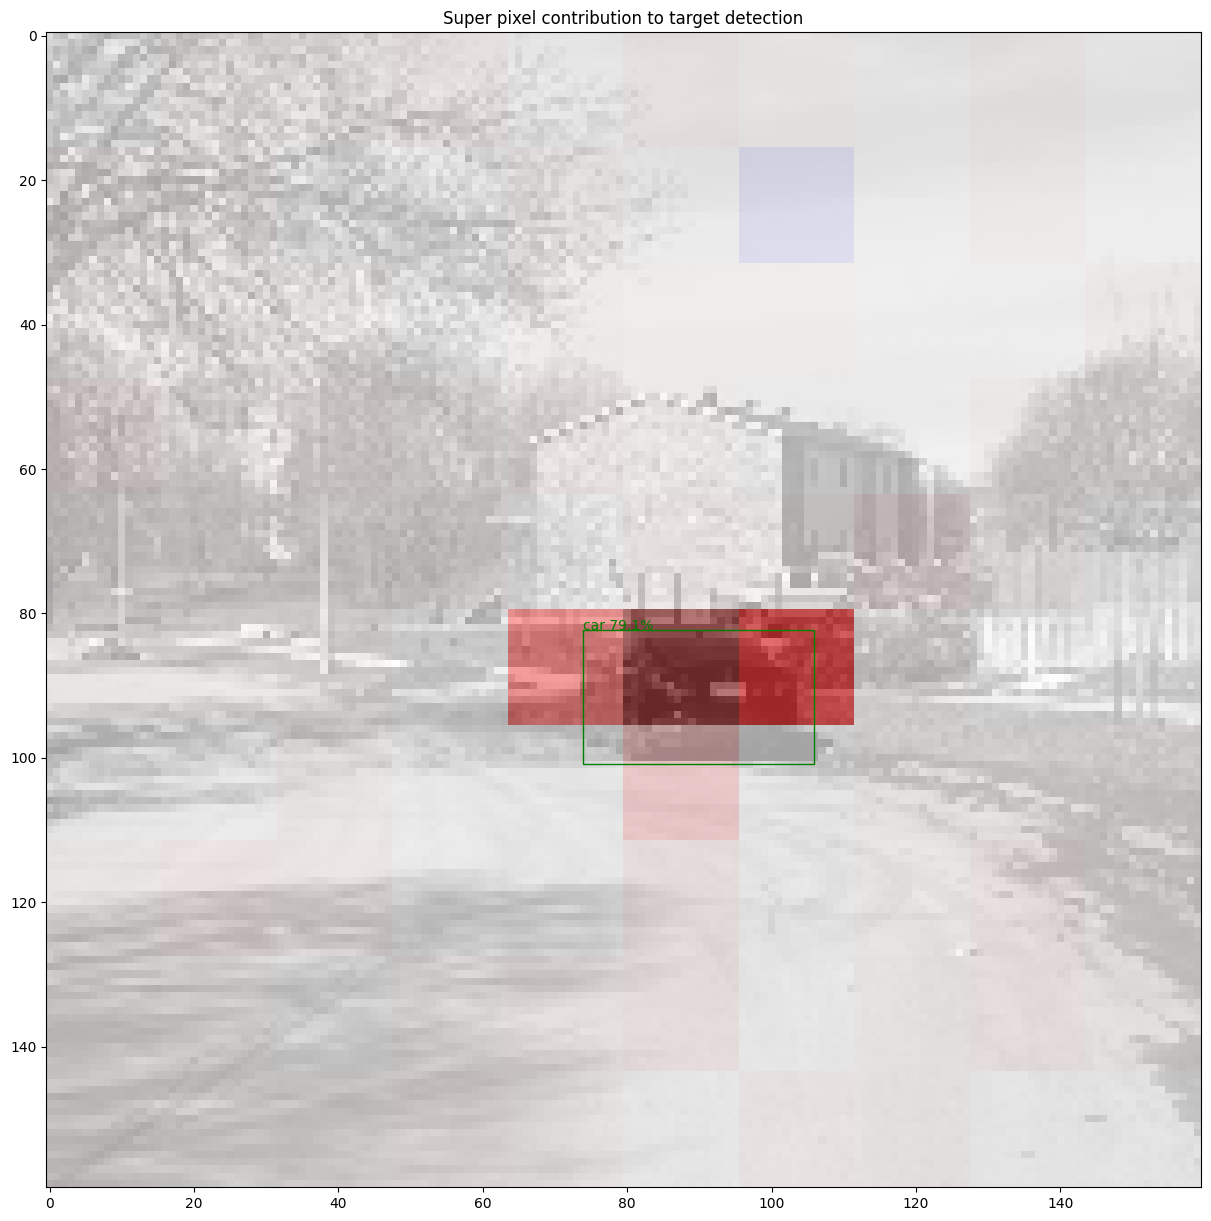

In [ ]:
# plot image and shap values for super pixels on top
fig, ax = plt.subplots(1, 1, figsize=(15,15))
ax.set_title("Super pixel contribution to target detection")
ax.imshow(img_gray, alpha=0.7, cmap='gray', vmin=0, vmax=1)
ax.imshow(shap_to_pixel, cmap=plt.cm.seismic, vmin=0, vmax=1, alpha=0.5)

# Add bounding box of target
label = f"{model.names[int(target[5])]} {target[4]:0.1%}"
plt.text(target[0], target[1], label, color="green")
bbox = patches.Rectangle(target[:2], target[2]-target[0], target[3]-target[1], linewidth=1, edgecolor='g', facecolor='none')
ax.add_patch(bbox)
plt.show()